In [1]:
import numpy as np
from pydub import AudioSegment
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

In [2]:
TARGET_FILE = "musica.mp3"
SIDECHAIN_FILE = "narracao.wav"
OUTPUT_FILE = "output.wav"
OUTPUT_MB_FILE = "output_multiband.wav"

In [3]:
def sidechain_compressor(target_signal, sidechain_signal, threshold_db=-20.0, ratio=4.0, attack_ms=10.0, release_ms=100.0, fs=44100):
    """
    A ferramenta de opressão sonora.
    target_signal: A música (que vai apanhar).
    sidechain_signal: A sua voz (que vai bater).
    """
    
    # 1. O detector é "monocelular". Ele não liga pro seu Soundstage estéreo gourmet.
    # A gente esmaga os canais pra tirar a média e saber a energia bruta.
    if len(sidechain_signal.shape) > 1:
        sidechain_mono = np.mean(sidechain_signal, axis=1)
    else:
        sidechain_mono = sidechain_signal
    
    # Tira o valor absoluto porque áudio negativo também é energia (física básica, parça).
    sidechain_abs = np.abs(sidechain_mono)
    
    # Matemática pra calcular a velocidade da voadora (Attack) 
    # e a velocidade do pedido de desculpas (Release).
    # Exponencial negativa porque a natureza odeia linhas retas.
    attack_coeff = np.exp(-1.0 / (fs * attack_ms / 1000.0))
    release_coeff = np.exp(-1.0 / (fs * release_ms / 1000.0))
    
    # --- AQUI COMEÇA O CRIME DE PERFORMANCE ---
    # Envelope follower: Seguir o volume do áudio.
    envelope = np.zeros_like(sidechain_abs)
    current_envelope = 0.0
    
    # ALERTA: Loop 'for' em Python processando áudio sample por sample.
    # Isso é mais lento que o suporte da sua operadora de internet.
    # Se fosse C++, rodava em nanosegundos. Aqui, vai dar tempo de passar um café.
    for i in range(len(sidechain_abs)):
        sample = sidechain_abs[i]
        if sample > current_envelope:
            # Fase de Ataque: O sinal subiu? Senta a marreta rápido.
            current_envelope = attack_coeff * current_envelope + (1 - attack_coeff) * sample
        else:
            # Fase de Release: O sinal desceu? Solta o pescoço da música devagar.
            current_envelope = release_coeff * current_envelope + (1 - release_coeff) * sample
        envelope[i] = current_envelope
    # --- FIM DA TORTURA DE CPU ---

    # Evita log de zero (porque dividir por zero cria buracos negros).
    envelope = np.maximum(envelope, 1e-9)
    # Transforma pra Decibéis, a língua que engenheiros de áudio falam pra parecerem inteligentes.
    envelope_db = 20 * np.log10(envelope)
    
    # Calcula o quanto a gente vai roubar de volume.
    gain_reduction_db = np.zeros_like(envelope_db)
    
    # A lógica da mãe irritada:
    # "Se o volume (envelope) passar do limite (Threshold), você apanha proporcionalmente (Ratio)."
    mask = envelope_db > threshold_db
    gain_reduction_db[mask] = (threshold_db - envelope_db[mask]) * (1 - 1/ratio)
    
    # Volta de dB pra linear, porque o computador não sabe multiplicar em escala logarítmica.
    gain_linear = 10 ** (gain_reduction_db / 20)
    
    # 2. Aplica a punição na música (Sinal Alvo).
    if len(target_signal.shape) > 1:
        # Se for estéreo, multiplica o ganho nos dois canais.
        # numpy.newaxis é a gambiarra pra matriz casar dimensão.
        output_signal = target_signal * gain_linear[:, np.newaxis]
    else:
        output_signal = target_signal * gain_linear
    
    # Devolve o áudio processado e a curva de ganho 
    # (pra você plotar no matplotlib e fingir que entende de DSP).
    return output_signal, gain_linear

In [4]:
def load_audio_universal(filename):
    print(f"Tentando decodificar a lasanha digital: {filename}...")

    audio = AudioSegment.from_file(filename)
    fs = audio.frame_rate

    data = np.array(audio.get_array_of_samples())

    if audio.channels == 2:
        data = data.reshape((-1, 2))

    bit_depth = audio.sample_width * 8
    max_val = float(1 << (bit_depth - 1))

    data = data.astype(np.float32) / max_val

    return fs, data

In [5]:
print(f"Lendo arquivos: {TARGET_FILE} e {SIDECHAIN_FILE}...")

# Carregando os áudios. 
# Se der erro aqui, é porque o usuário mentiu sobre o caminho do arquivo.
fs_t, target_signal = load_audio_universal(TARGET_FILE)
fs_s, sidechain_signal = load_audio_universal(SIDECHAIN_FILE)

# --- A GUILHOTINA DO NUMPY ---
# O NumPy não aceita arrays de tamanhos diferentes.
# Se a música tem 3 minutos e a voz tem 10 segundos, a música perde as pernas.
# A lei é clara: nivela por baixo.
min_len = min(len(target_signal), len(sidechain_signal))
target_signal = target_signal[:min_len]
sidechain_signal = sidechain_signal[:min_len]

# Esmagando o palco sonoro estéreo em um canal mono triste apenas para análise.
# O compressor precisa saber a "energia média", ele não liga se o violino tá na esquerda.
target_mono = np.mean(target_signal, axis=1) if len(target_signal.shape) > 1 else target_signal
sidechain_mono = np.mean(sidechain_signal, axis=1) if len(sidechain_signal.shape) > 1 else sidechain_signal

print("Iniciando o espancamento do áudio (Compressão)...")
# O coração da maldade.
# Threshold -25dB: "Passou daqui, apanha".
# Ratio 10.0: "Apanha com força de um caminhão".
output_signal, gain_curve = sidechain_compressor(
    target_signal, 
    sidechain_signal, 
    threshold_db=-25.0, 
    ratio=10.0, 
    attack_ms=5.0, 
    release_ms=200.0, 
    fs=fs_t
)

# Recalculando mono só pra desencargo de consciência (ou pra plotar gráfico depois).
output_mono = np.mean(output_signal, axis=1) if len(output_signal.shape) > 1 else output_signal

# --- NORMALIZAÇÃO DA MÚSICA ---
# Antes de misturar, vamos garantir que a música (que acabou de apanhar) 
# ocupe todo o espaço disponível no teto digital (0dBFS).
max_val = np.max(np.abs(output_signal))
if max_val > 0:
    output_signal /= max_val 

# --- A GAMBIARRA DO ESTÉREO ---
# Se a música sai em Estéreo (2 canais) e a sua voz gravada no microfone barato é Mono (1 canal),
# a matemática falha. Precisamos fazer uma "mitose" na voz.
if len(output_signal.shape) > 1 and len(sidechain_signal.shape) == 1:
    print("Expandindo voz mono para estéreo na marra...")
    # O np.newaxis cria uma dimensão fantasma, duplicando o sinal.
    sidechain_signal = sidechain_signal[:, np.newaxis]

# --- O CASAMENTO (MIXAGEM) ---
# Aqui somamos os dois sinais.
mixed_signal = output_signal + sidechain_signal

# --- O SEGURANÇA DE BALADA (ANTI-CLIPPING) ---
# Se Som A (1.0) + Som B (1.0) = 2.0, seu alto-falante rasga.
# Se passar de 1.0, a gente normaliza tudo pra baixo proporcionalmente.
max_mix_val = np.max(np.abs(mixed_signal))

if max_mix_val > 1.0:
    print(f"Opa! O sinal somado bateu {max_mix_val:.2f}. Normalizando pra não clipar...")
    mixed_signal /= max_mix_val
else:
    print("Mixagem segura. Nenhum bit foi ferido durante o processo.")

print("Escrevendo o arquivo final...")
# Convertendo float32 (luxo) de volta para int16 (padrão de camponês) para o WAV funcionar.
# Multiplica por 32767 porque é o limite do short integer.
wav.write(OUTPUT_FILE, fs_t, (mixed_signal * np.iinfo(np.int16).max).astype(np.int16))

print(f"SUCESSO: Arquivo salvo como {OUTPUT_FILE}. Seus vizinhos vão adorar.")

Lendo arquivos: musica.mp3 e narracao.wav...
Tentando decodificar a lasanha digital: musica.mp3...
Tentando decodificar a lasanha digital: narracao.wav...
Iniciando o espancamento do áudio (Compressão)...
Expandindo voz mono para estéreo na marra...
Opa! O sinal somado bateu 1.09. Normalizando pra não clipar...
Escrevendo o arquivo final...
SUCESSO: Arquivo salvo como output.wav. Seus vizinhos vão adorar.


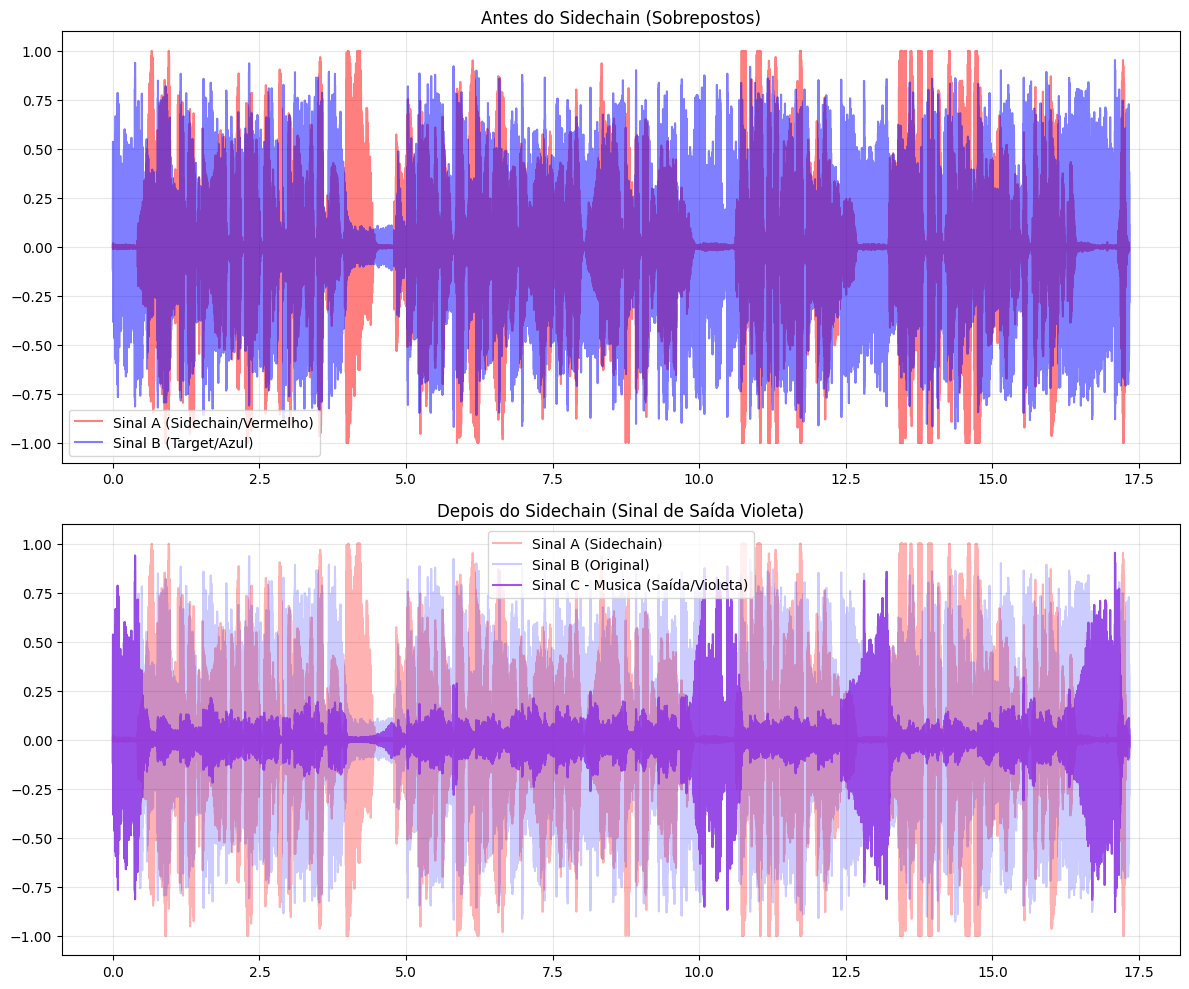

In [6]:
plt.figure(figsize=(12, 10))
t = np.arange(len(target_mono)) / fs_t

# Plot 1: Antes do Sidechain (Vermelho e Azul)
plt.subplot(2, 1, 1)
plt.title("Antes do Sidechain (Sobrepostos)")
plt.plot(t, sidechain_mono, color='red', alpha=0.5, label='Sinal A (Sidechain/Vermelho)')
plt.plot(t, target_mono, color='blue', alpha=0.5, label='Sinal B (Target/Azul)')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Depois do Sidechain (Vermelho, Azul e Violeta)
plt.subplot(2, 1, 2)
plt.title("Depois do Sidechain (Sinal de Saída Violeta)")
plt.plot(t, sidechain_mono, color='red', alpha=0.3, label='Sinal A (Sidechain)')
plt.plot(t, target_mono, color='blue', alpha=0.2, label='Sinal B (Original)')
plt.plot(t, output_mono, color='blueviolet', alpha=0.8, label='Sinal C - Musica (Saída/Violeta)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig("sidechain_analysis.png")

In [7]:
from scipy import signal
import numpy as np

def sidechain_compressor_spectral(target_signal, sidechain_signal, threshold_db=-40.0, ratio=4.0, attack_ms=10.0, release_ms=100.0, fs=44100):
    """
    O FINAL BOSS: Compressor Sidechain Espectral (Multibanda).
    
    Em vez de abaixar o volume todo (burro e analógico), a gente abaixa SÓ as frequências 
    que estão incomodando (cirúrgico e digitalmente arrogante).
    
    Aviso: Esse código mastiga sua CPU como se fosse chiclete.
    """
    
    # 1. Preparação: O sidechain vira mono na marra.
    # O detector de volume não quer saber se sua voz tá na esquerda ou na direita, ele quer energia bruta.
    if len(sidechain_signal.shape) > 1:
        sidechain_mono = np.mean(sidechain_signal, axis=1)
    else:
        sidechain_mono = sidechain_signal

    # 2. STFT - Transformada de Fourier de Curto Termo
    # Tradução: A gente fatia o áudio em 2048 pedacinhos (janelas) e pergunta pra matemática:
    # "Quais frequências vivem aqui?". É o Princípio da Incerteza de Heisenberg aplicado a MP3.
    nperseg = 2048
    noverlap = nperseg // 4

    # "Sashimi de Áudio" do Sidechain (Sinal de Controle)
    # f=freqs, t=tempo, Zxx=Matriz Complexa (Onde a magia/pesadelo acontece)
    f, t_frames, Zxx_side = signal.stft(sidechain_mono, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # Magnitude: Jogamos a fase (imaginária) no lixo e ficamos com a força bruta.
    side_mag = np.abs(Zxx_side)

    # Target STFT (A Vítima)
    # Se for Estéreo, a vida do programador vira um inferno dimensional.
    is_stereo = len(target_signal.shape) > 1
    if is_stereo:
        # Temos que fatiar canal por canal e empilhar num cubo de dados 3D.
        Zxx_target_list = []
        for ch in range(target_signal.shape[1]):
            _, _, Zxx = signal.stft(target_signal[:, ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            Zxx_target_list.append(Zxx)
        Zxx_target = np.stack(Zxx_target_list, axis=-1)
    else:
        _, _, Zxx_target = signal.stft(target_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # 3. Envelope Follower Espectral
    # Aqui a gente cria um "engenheiro de som virtual" para CADA BIN DE FREQUÊNCIA.
    # São 1025 anões controlando faders independentes. Haja salário.
    
    # Convertendo tempo humano (ms) para "tempo de frame FFT" (matemática chata)
    frame_dur = (nperseg - noverlap) / fs
    attack_coeff = np.exp(-frame_dur / (attack_ms / 1000.0))
    release_coeff = np.exp(-frame_dur / (release_ms / 1000.0))
    
    env_spectral = np.zeros_like(side_mag)
    current_env = np.zeros(side_mag.shape[0])

    # O LOOP DA MORTE (Gargalo de Performance)
    # Iterar em Python é pedir pra sofrer. Mas é didático.
    for i in range(side_mag.shape[1]):
        mag_frame = side_mag[:, i] # O espectro neste exato momento
        
        # Comparação vetorial: "A frequência X subiu?" -> Ataque. "Desceu?" -> Release.
        mask_attack = mag_frame > current_env
        
        # Atualiza o envelope (suavização)
        current_env[mask_attack] = attack_coeff * current_env[mask_attack] + (1 - attack_coeff) * mag_frame[mask_attack]
        current_env[~mask_attack] = release_coeff * current_env[~mask_attack] + (1 - release_coeff) * mag_frame[~mask_attack]
        
        env_spectral[:, i] = current_env

    # 4. Cálculo da Punição (Gain Reduction)
    # Evita log de zero pra não criar um buraco negro no console.
    env_spectral = np.maximum(env_spectral, 1e-9)
    env_db = 20 * np.log10(env_spectral)
    
    gain_reduction_db = np.zeros_like(env_db)

    # A Lógica Cirúrgica:
    # Se minha voz é grave (200Hz), SÓ os bins de 200Hz apanham.
    # O prato da bateria (10kHz) continua tocando feliz. Isso é tecnologia, amigos.
    mask = env_db > threshold_db
    gain_reduction_db[mask] = (threshold_db - env_db[mask]) * (1 - 1/ratio)
    
    # Volta de dB (log) para Linear (multiplicação simples)
    gain_linear = 10 ** (gain_reduction_db / 20)

    # 5. O Retorno de Jedi (ISTFT)
    # A gente cola o sashimi de volta e tenta transformar num peixe vivo.
    if is_stereo:
        output_channels = []
        for ch in range(target_signal.shape[1]):
            # Aplica o ganho no domínio da frequência (Multiplicação Complexa)
            Zxx_out = Zxx_target[:, :, ch] * gain_linear
            # Transformada Inversa: A alquimia que transforma matemática de volta em som.
            _, x_out = signal.istft(Zxx_out, fs=fs, nperseg=nperseg, noverlap=noverlap)
            output_channels.append(x_out)
        output_signal = np.stack(output_channels, axis=-1)
    else:
        Zxx_out = Zxx_target * gain_linear
        _, output_signal = signal.istft(Zxx_out, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # A ISTFT tem problemas de arredondamento e bordas. 
    # A gente usa a tesoura sem dó pra garantir que cabe no array original.
    min_len = min(len(target_signal), len(output_signal))
    output_signal = output_signal[:min_len]

    # Gambiarra Visual:
    # Cria uma "média" do que aconteceu pra gente plotar um gráfico bonitinho depois.
    # É uma mentira estatística, mas fica bonito na thumbnail.
    gain_curve_viz = np.mean(gain_linear, axis=0)
    t_orig = np.arange(len(target_signal)) / fs
    gain_viz_interp = np.interp(t_orig, t_frames, gain_curve_viz)
    
    return output_signal, gain_viz_interp

In [8]:
output_signal, gain_curve = sidechain_compressor_spectral(
    target_signal, 
    sidechain_signal, 
    threshold_db=-50.0,
    ratio=10.0, 
    attack_ms=5.0, 
    release_ms=100.0, 
    fs=fs_t
)

output_mono = np.mean(output_signal, axis=1) if len(output_signal.shape) > 1 else output_signal


if len(output_signal.shape) > 1 and len(sidechain_signal.shape) == 1:
    print("Expandindo voz mono para estéreo na marra...")
    sidechain_signal = sidechain_signal[:, np.newaxis]

mixed_signal = output_signal + sidechain_signal
max_mix_val = np.max(np.abs(mixed_signal))

if max_mix_val > 1.0:
    print(f"Opa! O sinal somado bateu {max_mix_val:.2f}. Normalizando pra não clipar...")
    mixed_signal /= max_mix_val
else:
    print("Mixagem segura. Nenhum bit foi ferido.")
    
# Salvar Áudio
max_val = np.max(np.abs(mixed_signal))
if max_val > 0:
    mixed_signal /= max_val 
wav.write(OUTPUT_MB_FILE, fs_t, (mixed_signal * np.iinfo(np.int16).max).astype(np.int16))

Opa! O sinal somado bateu 1.63. Normalizando pra não clipar...


Gráfico de análise espectral atualizado.


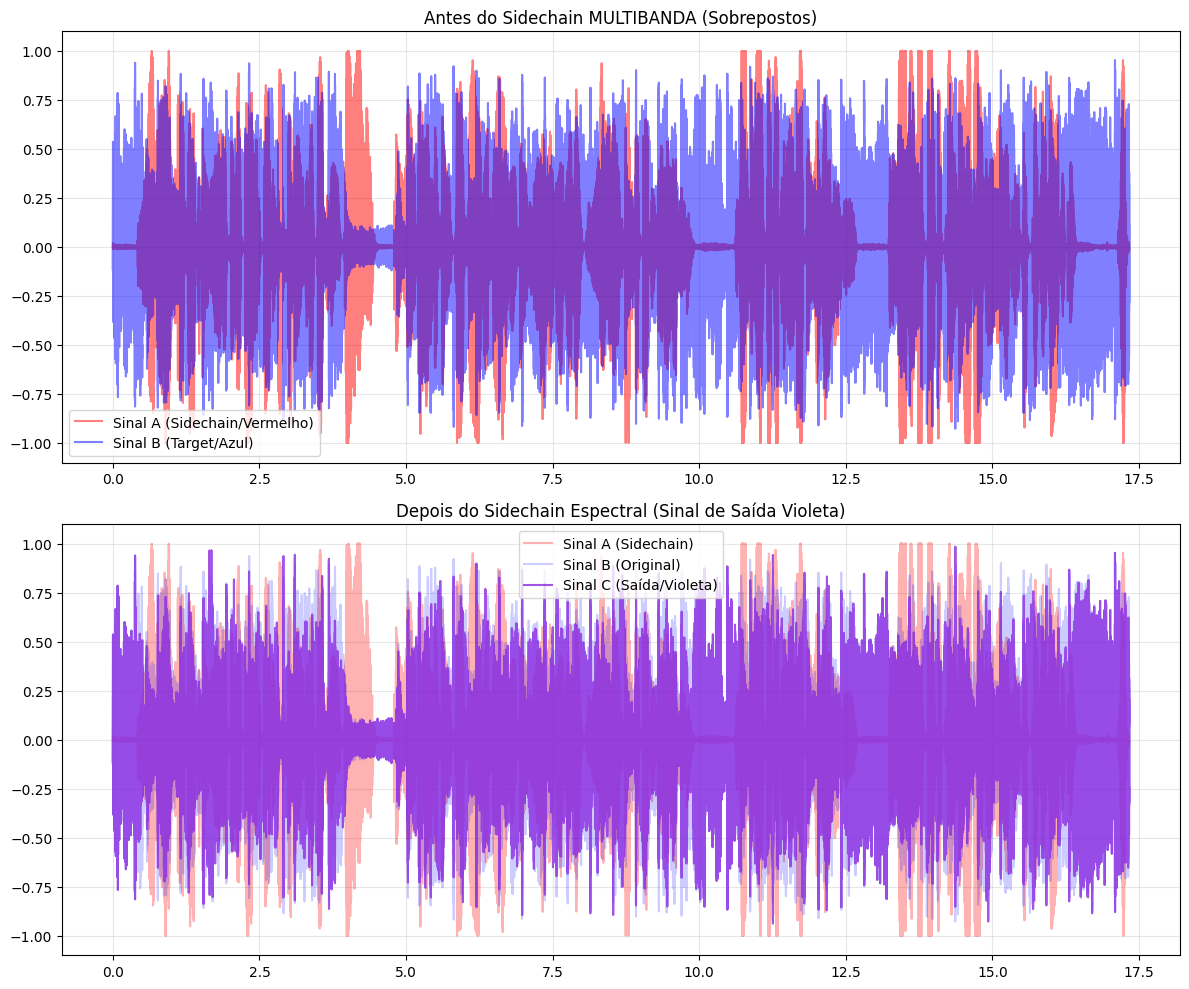

In [9]:
plt.figure(figsize=(12, 10))
t = np.arange(len(target_mono)) / fs_t

# Plot 1: Antes do Sidechain (Vermelho e Azul)
plt.subplot(2, 1, 1)
plt.title("Antes do Sidechain MULTIBANDA (Sobrepostos)")
plt.plot(t, sidechain_mono, color='red', alpha=0.5, label='Sinal A (Sidechain/Vermelho)')
plt.plot(t, target_mono, color='blue', alpha=0.5, label='Sinal B (Target/Azul)')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Depois do Sidechain (Vermelho, Azul e Violeta)
plt.subplot(2, 1, 2)
plt.title("Depois do Sidechain Espectral (Sinal de Saída Violeta)")
plt.plot(t, sidechain_mono, color='red', alpha=0.3, label='Sinal A (Sidechain)')
plt.plot(t, target_mono, color='blue', alpha=0.2, label='Sinal B (Original)')
plt.plot(t, output_mono, color='blueviolet', alpha=0.8, label='Sinal C (Saída/Violeta)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig("sidechain_analysis.png")
print("Gráfico de análise espectral atualizado.")

/tmp/ipykernel_809571/2170216208.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(SIDECHAIN_FILE)


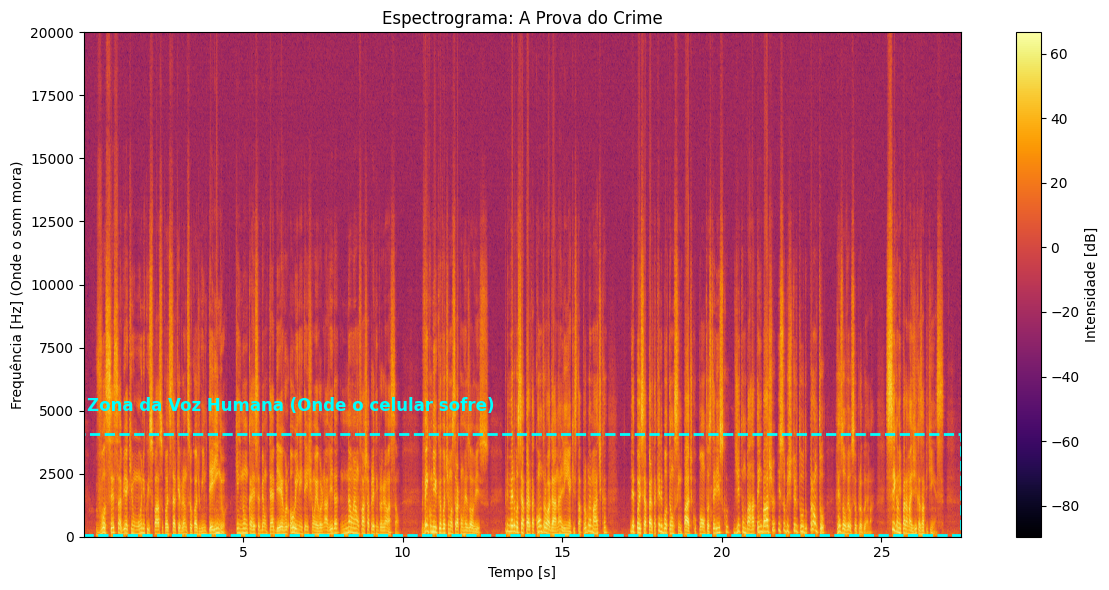

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

# Função pra carregar (usando a que a gente já fez ou wavfile puro)
# Se não tiver arquivo, gera um ruído branco pra testar
fs, data = wavfile.read(SIDECHAIN_FILE)
# Se for estéreo, esmaga pra mono
if len(data.shape) > 1:
    data = data.mean(axis=1)


# --- O ESPECTROGRAMA ---
# nperseg: Tamanho da janela. Quanto maior, mais resolução de freq, menos de tempo.
# 1024 ou 2048 são o "padrão ouro".
f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024, noverlap=512)

plt.figure(figsize=(12, 6))

# Pcolormesh é quem pinta o mapa de calor.
# Shading 'gouraud' deixa bonito e suave.
# Usamos Log na amplitude (10 * np.log10) porque o ouvido é logarítmico.
plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-9), shading='gouraud', cmap='inferno')

plt.ylim(0, 20000)

plt.ylabel('Frequência [Hz] (Onde o som mora)')
plt.xlabel('Tempo [s]')
plt.title('Espectrograma: A Prova do Crime')

# --- O RETÂNGULO DA VOZ HUMANA ---
# Desenha uma caixa mostrando onde a voz vive (aprox 80Hz a 1000Hz para fundamental/corpo)
# O resto pra cima são harmônicos e ar (ou música atrapalhando).
from matplotlib.patches import Rectangle
ax = plt.gca()
# (x, y), width, height
rect = Rectangle((0, 85), t[-1], 4000, linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--')
ax.add_patch(rect)
plt.text(0.1, 5000, 'Zona da Voz Humana (Onde o celular sofre)', color='cyan', fontsize=12, fontweight='bold')

plt.colorbar(label='Intensidade [dB]')
plt.tight_layout()
plt.show()